# 1.Install Dependencies

In [ ]:
!pip install keras==2.10.0 tensorboard==2.10.0 tensorflow-estimator==2.10.0


In [ ]:
!pip install tensorflow-intel==2.10.0

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
   



In [5]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!pip list

In [6]:
# Bringing tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [7]:
# Use the tensorflow datasets api to bring in the data source

ds =  tfds.load('fashion_mnist', split='train')

# 2. Visualize Data and Build Dataset

In [8]:
# Do some data transformation
import numpy as np

In [9]:
data_iterator = ds.as_numpy_iterator()

In [10]:
# Getting data out of the pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

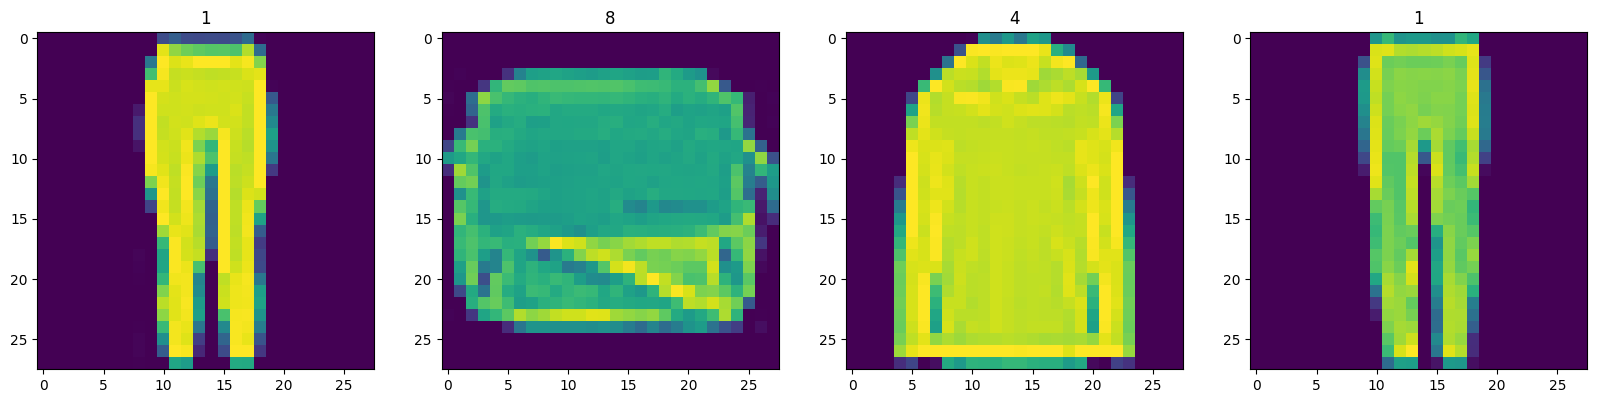

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch=data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [12]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image/255

In [13]:
# relaod the dataset
ds = tfds.load('fashion_mnist', split='train')

ds = ds.map(scale_images) 

ds = ds.cache()

ds = ds.shuffle(60000)

ds = ds.batch(120)

ds = ds.prefetch(64)


In [14]:
ds.as_numpy_iterator().next().shape

(120, 28, 28, 1)

# 3 Build Neural Network

## 3.1 Import Modeling Components

In [15]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 3.2 Build Generator

In [16]:
def build_generator():
    model  = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model
   
    

In [17]:
generator = build_generator()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [19]:
noise=np.random.randn(4,128,1)
img = generator.predict(noise)

1/1 [==============================] - 148s 148s/step


In [ ]:
img.shape

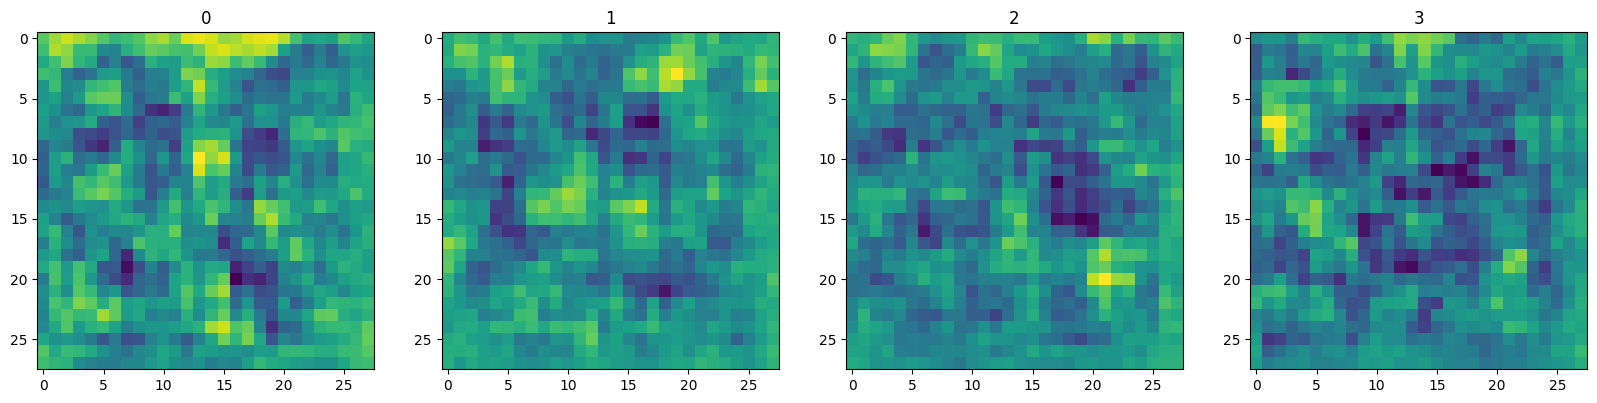

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
 
for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

## 3.3 Build our Discriminator


In [ ]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [ ]:
discriminator=build_discriminator()

In [ ]:
discriminator.summary()

In [ ]:
img.shape

In [ ]:
discriminator.predict(img)

# 4 Construct Custom Training loop

## 4.1 Setup Losses and Optimizers

In [ ]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:

gen_opt = Adam(learning_rate=0.0001) 
des_opt = Adam(learning_rate=0.00001) 
gen_loss = BinaryCrossentropy()
des_loss = BinaryCrossentropy()

## 4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to the subclass our training step
from tensorflow.keras.models import Model


In [ ]:
class GAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, gen_opt, des_opt, gen_loss, des_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.gen_opt = gen_opt
        self.des_opt = des_opt
        self.gen_loss = gen_loss
        self.des_loss = des_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            y_out_real = self.discriminator(real_images, training=True) 
            y_out_fake = self.discriminator(fake_images, training=True)
            y_out_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(y_out_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(y_out_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, y_out_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instnace of subclass model
fash_gan= GAN(generator,discriminator)

In [ ]:
fash_gan.compile(gen_opt, des_opt, gen_loss, des_loss)

# 4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class Model_Monitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))


## 4.3 Train

In [ ]:
ds.as_numpy_iterator().next()

In [ ]:
hist = fash_gan.fit(ds, epochs=2000,callbacks=[Model_Monitor()])

## 4.4 Review performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()


# Test out the generator

## 5.1 Generate images

In [ ]:
generator_model.save('generator.h5')
discriminator_model.save('discriminator.h5')

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])